In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, \
    confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np

In [7]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.001, epochs=1000, batch_size=32):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.test_acc = None

    def sigmoid(self, z):
        z = np.clip(z, -500, 500) 
        return 1 / (1 + np.exp(-z))
    
    def hypothesis(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def compute_accuracy(self, y_true, y_pred):
        predictions = (y_pred > 0.5).astype(int)
        return np.mean(predictions == y_true)
    
    def fit(self, X_train, y_train, X_val, y_val):
        n_samples, n_features = X_train.shape
        self.weights = np.random.rand(n_features)
        
        print(self.weights)
        self.bias = 0
        
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_train, y_train = X_train[indices], y_train[indices]
            
            for start in range(0, n_samples, self.batch_size):
                end = min(start + self.batch_size, n_samples)
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                y_pred = self.hypothesis(X_batch)

                error = y_pred - y_batch
                gradient_weights = np.dot(X_batch.T, error) / self.batch_size
                gradient_bias = np.mean(error)
                
                self.weights -= self.learning_rate * gradient_weights
                self.bias -= self.learning_rate * gradient_bias

            train_pred = self.hypothesis(X_train)
            val_pred = self.hypothesis(X_val)
            
            train_loss = self.compute_loss(y_train, train_pred)
            val_loss = self.compute_loss(y_val, val_pred)
            
            train_acc = self.compute_accuracy(y_train, train_pred)
            val_acc = self.compute_accuracy(y_val, val_pred)
            
            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)
            self.train_acc.append(train_acc)
            self.val_acc.append(val_acc)
            
            print(f"Epoch {epoch+1}/{self.epochs}")
            print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    def evaluate_test_accuracy(self, X_test, y_test):
        test_pred = self.hypothesis(X_test)
        self.test_acc = self.compute_accuracy(y_test, test_pred)
        print(f"Test Accuracy: {self.test_acc:.4f}")

    def evaluate_metrics(self, X_val, y_val):
        val_pred = self.hypothesis(X_val)
        val_pred_labels = (val_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, val_pred_labels)
        print("Confusion Matrix:\n", cm)
        
        precision = precision_score(y_val, val_pred_labels, zero_division=0)
        recall = recall_score(y_val, val_pred_labels)
        f1 = f1_score(y_val, val_pred_labels)
        roc_auc = roc_auc_score(y_val, val_pred)
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC-AUC Score: {roc_auc:.4f}")
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
    
    
    def plot_metrics(self):
        plt.figure(figsize=(12, 5))
    
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Over Epochs')
    
        plt.subplot(1, 2, 2)
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        if self.test_acc is not None:
            plt.axhline(y=self.test_acc, color='r', linestyle='--', label=f'Test Accuracy ({self.test_acc:.4f})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Over Epochs')
    
        plt.show()

In [2]:
data = pd.read_csv('Heart Disease.csv')
print(data.info())
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  HeartDisease     4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB
None
male    

In [3]:
X = data.drop('HeartDisease', axis=1)  
y = data['HeartDisease']

numerical_cols = ['age', 'cigsPerDay', 'BPMeds', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
categorical_cols = ['education', 'currentSmoker', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'male']

numerical_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

print(X.isna().sum())

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
dtype: int64


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15 / (1 - 0.15), random_state=42)

print(f"Training set: {X_train[0:1].shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (1, 15), (2966,)
Validation set: (636, 15), (636,)
Test set: (636, 15), (636,)


[0.55008416 0.01845389 0.90838007 0.15400554 0.46815962 0.65046405
 0.5566369  0.79184358 0.8749207  0.22679643 0.78020265 0.25432305
 0.59135155 0.59308909 0.23227767]
Epoch 1/200
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 2/200
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 3/200
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 4/200
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 5/200
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 6/200
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 7/200
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 8/200
Trainin

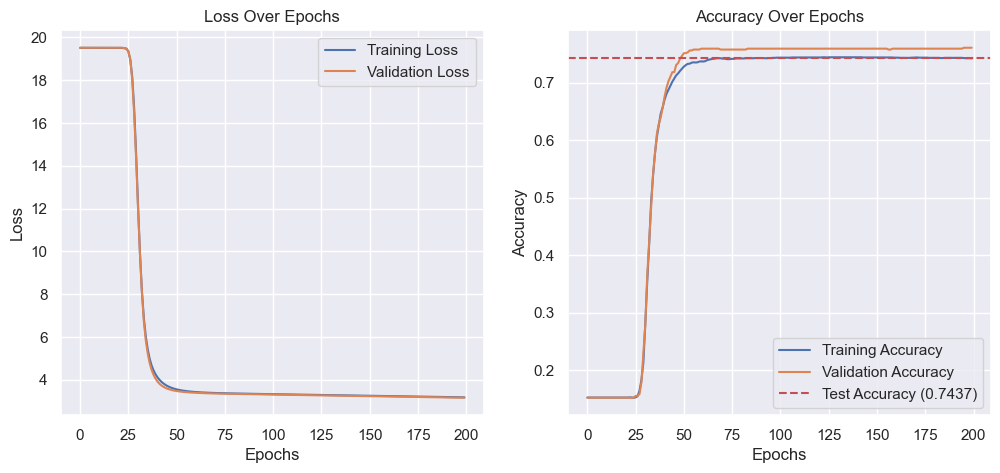

Test Accuracy: 0.7437


In [11]:
model = MyLogisticRegression(learning_rate=0.0001, epochs=200, batch_size=X_train.shape[0])
model.fit(X_train.values, y_train.values, X_val.values, y_val.values)
model.evaluate_test_accuracy(X_test.values, y_test.values)
model.plot_metrics()
print(f"Test Accuracy: {model.test_acc:.4f}")

# A: Observations

### Model Convergence

1. **Fast convergence**: The model learns quickly, stabilizing around epoch 50.

2. **Smooth learning**: No erratic jumps in loss or accuracy, suggesting a good learning rate.

3. **No overfitting**: Training and validation curves stay close together.

4. **Consistent performance**: Final accuracy (~74%) is similar across training, validation, and test sets.

Overall, the model shows good learning behavior.


In [12]:
class MinMaxScaler:
    def __init__(self, feature_range=(0, 1)):
        self.min = None
        self.max = None
        self.feature_range = feature_range

    def fit(self, X):
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)

    def transform(self, X):
        X_scaled = (X - self.min) / (self.max - self.min)
        X_scaled = X_scaled * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]
        return X_scaled

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

[[0.         0.5        0.         ... 0.26223946 0.13131313 0.10451977]
 [0.         0.39473684 0.         ... 0.46097916 0.26262626 0.11855015]
 [0.         0.26315789 0.66666667 ... 0.16117305 0.43434343 0.12711864]
 ...
 [0.         0.71052632 0.         ... 0.23194377 0.36363636 0.12146893]
 [1.         0.42105263 0.33333333 ... 0.15947649 0.34343434 0.12146893]
 [0.         0.47368421 0.66666667 ... 0.06592341 0.2020202  0.11855015]]
[0.79648173 0.01699768 0.95100615 0.52609057 0.3869154  0.34125103
 0.46425479 0.90305575 0.38584891 0.7381883  0.40953712 0.39930409
 0.70721021 0.69210851 0.74740049]
Epoch 1/1000
Training Loss: 1.9074, Training Accuracy: 0.1527
Validation Loss: 1.9297, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 1.8955, Training Accuracy: 0.1527
Validation Loss: 1.9178, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 1.8837, Training Accuracy: 0.1527
Validation Loss: 1.9060, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 1.8719, Traini

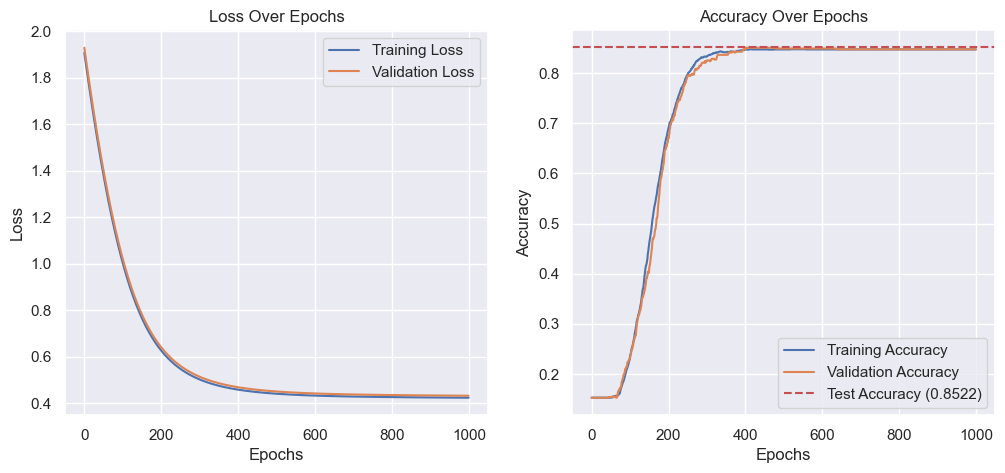

Test Accuracy: 0.8522
[0.27593011 0.12772393 0.59530615 0.59452731 0.81073702 0.62289399
 0.07881925 0.18216605 0.74289014 0.58174137 0.5798442  0.77960388
 0.14582268 0.23156633 0.0267887 ]
Epoch 1/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 5/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 6/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 7/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accurac

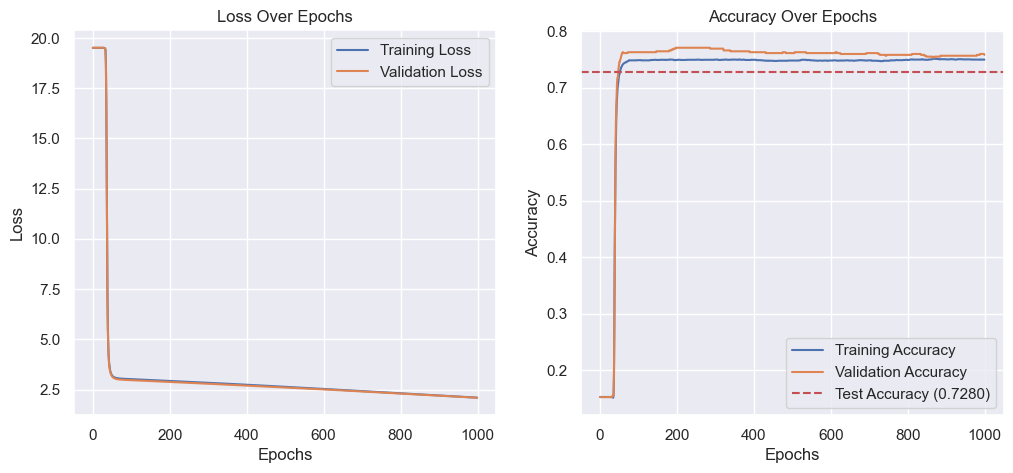

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

print(X_train_scaled)

model = MyLogisticRegression(learning_rate=0.01, epochs=1000, batch_size=X_train.shape[0])
model.fit(X_train_scaled, y_train.values, X_val_scaled, y_val.values)
model.evaluate_test_accuracy(X_test_scaled, y_test.values)
model.plot_metrics()
print(f"Test Accuracy: {model.test_acc:.4f}")

model2 = MyLogisticRegression(learning_rate=0.0001, epochs=1000, batch_size=X_train.shape[0])
model2.fit(X_train.values, y_train.values, X_val.values, y_val.values)
model2.evaluate_test_accuracy(X_test.values, y_test.values)
model2.plot_metrics()

# B: Model Performance Comparison
### Impact of Feature Scaling on Model Convergence

- **With MinMax Scaling (First Plot):**
    - The accuracy plateau is not sharp it is smooth
    - The model converges much faster (within ~200 epochs).
    - Both training and validation losses decrease smoothly.
    - Accuracy reaches ~85%, indicating good generalization.

- **Without Scaling (Second Plot):**
    - Convergence is slower with high initial loss values.
    - Takes more epochs to stabilize.
    - Accuracy plateaus at ~74%, showing suboptimal performance.

**Conclusion:**  
Feature scaling made all features contribute equally, leading to faster and more efficient convergence in batch gradient descent.



[0.96502117 0.526989   0.88690381 0.55568005 0.53382258 0.44041055
 0.71702716 0.00457205 0.91301537 0.67179616 0.82539866 0.72887636
 0.35263957 0.90770485 0.3459377 ]
Epoch 1/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 5/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 6/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 7/1000
Training Loss: 19.5091, Training Accuracy: 0.1527
Validation Loss: 19.5140, Validation Accuracy: 0.1525
Epoch 8/1000

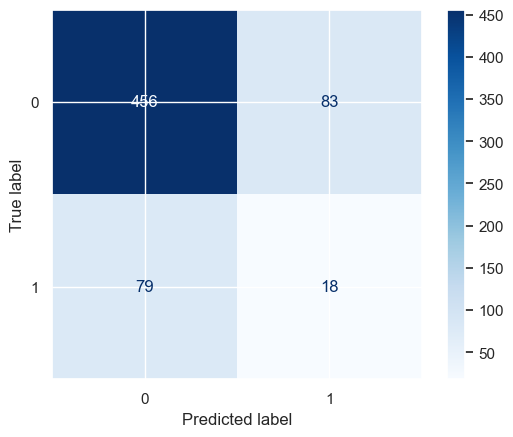

Test Accuracy: 0.7311


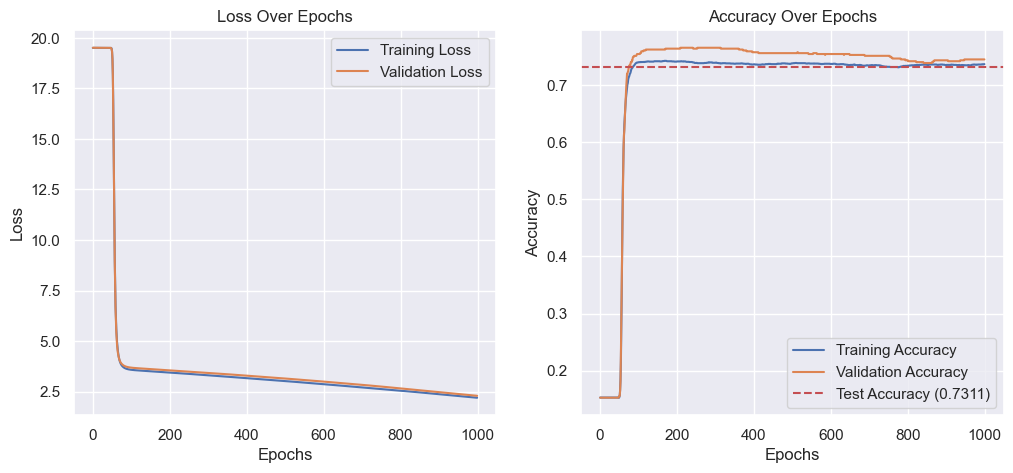

In [14]:
model = MyLogisticRegression(learning_rate=0.0001, epochs=1000, batch_size=X_train.shape[0])
model.fit(X_train.values, y_train.values, X_val.values, y_val.values)
model.evaluate_metrics(X_val.values, y_val.values)
model.evaluate_test_accuracy(X_test.values, y_test.values)
model.plot_metrics()    

# C: Observation

### Model Performance Analysis Based on Metrics

- **Precision (0.2529):**  
  - Out of all the positive predictions, only 25.29% were correct. This indicates the model has a high false-positive rate.

- **Recall (0.2268):**  
  - Only 22.68% of the actual positives were identified.

- **F1 Score (0.2391):**  
  - A harmonic mean of precision and recall. The low score reflects, signaling the model’s difficulty with positive class identification.

- **ROC-AUC Score (0.5712):**  
  - This is slightly above random guessing (0.5). It indicates that the model has limited ability to distinguish between the positive and negative classes.

**Conclusion:**  
The model struggles particularly with identifying positive instances, which is reflected in low precision, recall, and F1 score. The high true negative count suggests it performs better for the negative class, but overall, the performance is optimal.



[0.02351141 0.71595664 0.04061291 0.33552371 0.30079583 0.79652544
 0.55839297 0.67619652 0.21209263 0.9065314  0.91134489 0.41138962
 0.17275965 0.64847647 0.25296168]
Epoch 1/1000
Training Loss: 1.2696, Training Accuracy: 0.1527
Validation Loss: 1.2735, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 1.0505, Training Accuracy: 0.1537
Validation Loss: 1.0542, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 0.8840, Training Accuracy: 0.2320
Validation Loss: 0.8876, Validation Accuracy: 0.2484
Epoch 4/1000
Training Loss: 0.7617, Training Accuracy: 0.4862
Validation Loss: 0.7654, Validation Accuracy: 0.5079
Epoch 5/1000
Training Loss: 0.6734, Training Accuracy: 0.6537
Validation Loss: 0.6771, Validation Accuracy: 0.6336
Epoch 6/1000
Training Loss: 0.6100, Training Accuracy: 0.7323
Validation Loss: 0.6139, Validation Accuracy: 0.7107
Epoch 7/1000
Training Loss: 0.5643, Training Accuracy: 0.7680
Validation Loss: 0.5683, Validation Accuracy: 0.7531
Epoch 8/1000
Training Loss

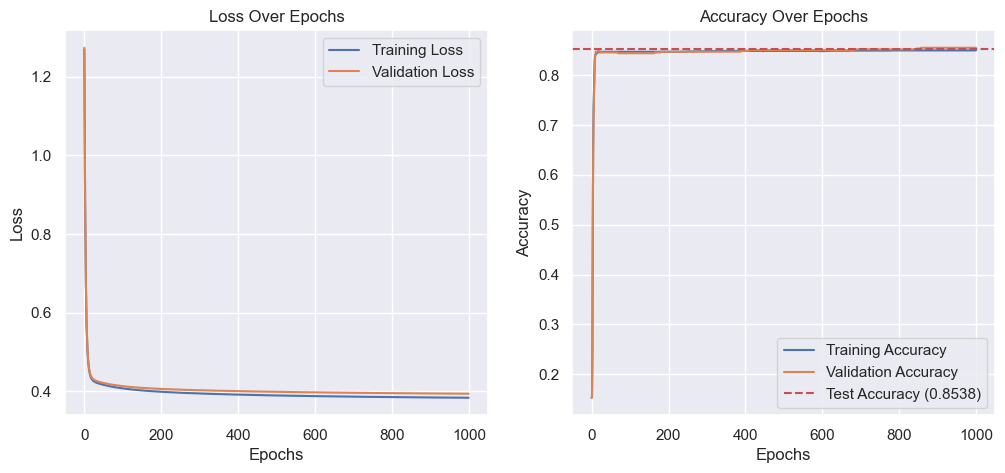

In [15]:
#Stochastic Gradient Descent
model = MyLogisticRegression(learning_rate=0.0001, epochs=1000, batch_size=1)
model.fit(X_train_scaled, y_train.values, X_val_scaled, y_val)
model.evaluate_test_accuracy(X_test_scaled, y_test.values)
model.plot_metrics()

[0.8918246  0.03640511 0.9496139  0.74528765 0.4731203  0.31170537
 0.4497816  0.38166796 0.86872414 0.76129453 0.87952555 0.57385026
 0.91156051 0.85579338 0.8465889 ]
Epoch 1/1000
Training Loss: 2.1493, Training Accuracy: 0.1527
Validation Loss: 2.1570, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 2.1374, Training Accuracy: 0.1527
Validation Loss: 2.1451, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 2.1256, Training Accuracy: 0.1527
Validation Loss: 2.1333, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 2.1138, Training Accuracy: 0.1527
Validation Loss: 2.1215, Validation Accuracy: 0.1525
Epoch 5/1000
Training Loss: 2.1021, Training Accuracy: 0.1527
Validation Loss: 2.1098, Validation Accuracy: 0.1525
Epoch 6/1000
Training Loss: 2.0904, Training Accuracy: 0.1527
Validation Loss: 2.0981, Validation Accuracy: 0.1525
Epoch 7/1000
Training Loss: 2.0787, Training Accuracy: 0.1527
Validation Loss: 2.0864, Validation Accuracy: 0.1525
Epoch 8/1000
Training Loss

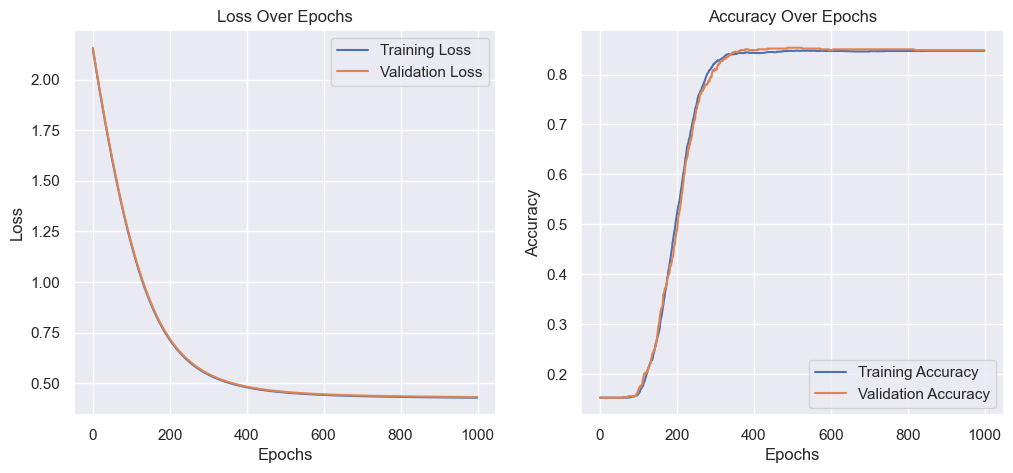

Test Accuracy: 0.8538


In [16]:
# mini batch
model2 = MyLogisticRegression(learning_rate=0.0001, epochs=1000, batch_size=32)
model2.fit(X_train_scaled, y_train.values, X_val_scaled, y_val.values)
model2.plot_metrics()
model2.evaluate_test_accuracy(X_test_scaled, y_test.values)

[0.51480312 0.77009302 0.03181403 0.88326549 0.42981279 0.04408531
 0.95010835 0.18208071 0.1401396  0.77625535 0.78302369 0.12002941
 0.8064453  0.9234461  0.69871097]
Epoch 1/1000
Training Loss: 1.8917, Training Accuracy: 0.1527
Validation Loss: 1.8788, Validation Accuracy: 0.1525
Epoch 2/1000
Training Loss: 1.8848, Training Accuracy: 0.1527
Validation Loss: 1.8719, Validation Accuracy: 0.1525
Epoch 3/1000
Training Loss: 1.8780, Training Accuracy: 0.1527
Validation Loss: 1.8651, Validation Accuracy: 0.1525
Epoch 4/1000
Training Loss: 1.8711, Training Accuracy: 0.1527
Validation Loss: 1.8582, Validation Accuracy: 0.1525
Epoch 5/1000
Training Loss: 1.8643, Training Accuracy: 0.1527
Validation Loss: 1.8514, Validation Accuracy: 0.1525
Epoch 6/1000
Training Loss: 1.8575, Training Accuracy: 0.1527
Validation Loss: 1.8446, Validation Accuracy: 0.1525
Epoch 7/1000
Training Loss: 1.8507, Training Accuracy: 0.1527
Validation Loss: 1.8378, Validation Accuracy: 0.1525
Epoch 8/1000
Training Loss

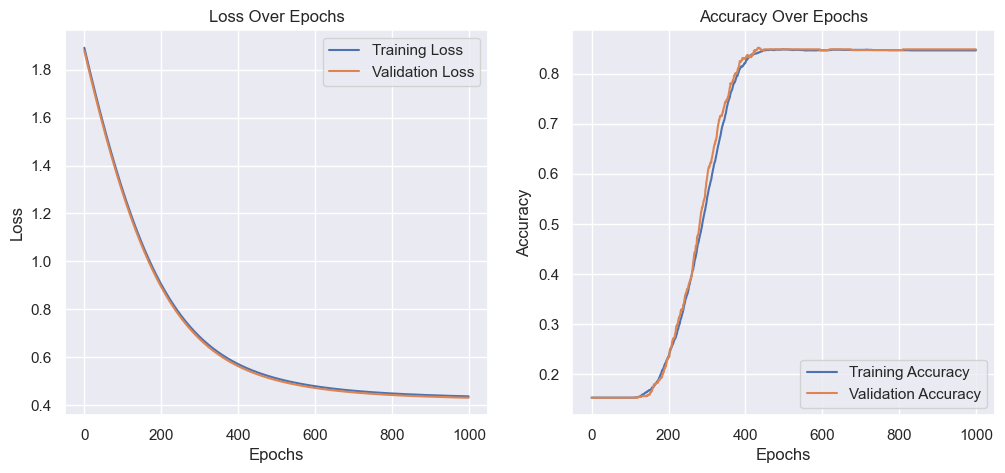

Test Accuracy: 0.8522


In [17]:
# mini batch
model3 = MyLogisticRegression(learning_rate=0.0001, epochs=1000, batch_size=52)
model3.fit(X_train_scaled, y_train.values, X_val_scaled, y_val.values)
model3.plot_metrics()
model3.evaluate_test_accuracy(X_test_scaled, y_test.values)


# D: Comparison of Optimization Methods (SGD, Mini-batch GD, Batch GD)

### Trade-offs: Stochastic GD vs Mini-batch GD (Batch Sizes 32, 52)

### 1. Convergence Speed
- **Stochastic GD**: 
  - Faster initial convergence but higher fluctuations.
- **Mini-batch GD**: 
  - Slower than SGD initially, but smoother convergence with increasing batch size.

### 2. Stability
- **Stochastic GD**: 
  - Less stable due to frequent weight updates, causing oscillations.
- **Mini-batch GD**: 
  - More stable, with fewer oscillations as batch size increases (52 > 32).



In [18]:
k = 5 
indices = np.arange(X_train.shape[0])
np.random.seed(42)
np.random.shuffle(indices)

fold_sizes = np.full(k, X_train.shape[0] // k) 
fold_sizes[:X_train.shape[0] % k] += 1 

In [20]:
from sklearn.metrics import accuracy_score

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
precisions = []
recalls = []
f1_scores = []

current = 0
for fold in range(k):
    start, end = current, current+fold_sizes[fold]
    val_indices = indices[start:end]
    train_indices = np.concatenate((indices[:start], indices[end:]))
    X_fold_train, X_fold_val = X_train.values[train_indices], X_train.values[val_indices]
    y_fold_train, y_fold_val = y_train.values[train_indices], y_train.values[val_indices]

    model = MyLogisticRegression(learning_rate=0.0001, epochs=1000, batch_size=X_train.shape[0])

    model.fit(X_fold_train, y_fold_train, X_fold_val, y_fold_val)

    y_val_pred_proba = model.hypothesis(X_fold_val)  
    y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

    train_losses.append(model.train_loss[-1])
    val_losses.append(model.val_loss[-1])
    train_accuracies.append(model.train_acc[-1])

    val_acc = accuracy_score(y_fold_val, y_val_pred)
    precision = precision_score(y_fold_val, y_val_pred, average='binary', zero_division=0)
    recall = recall_score(y_fold_val, y_val_pred, average='binary', zero_division=0)
    f1 = f1_score(y_fold_val, y_val_pred, average='binary', zero_division=0)

    val_accuracies.append(val_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    current = end
    
    print("------------------------------------------------------------------------------------------------")

print("\nCross-Validation Results:")
print(f"Average Training Accuracy: {np.mean(train_accuracies):.4f} ± {np.std(train_accuracies):.4f}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
print(f"Average Training Loss: {np.mean(train_losses):.4f} ± {np.std(train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

X_final_train, X_final_val, y_final_train, y_final_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

[0.6068885  0.61170724 0.01081855 0.74336171 0.69659553 0.57984113
 0.63516068 0.49549606 0.5523489  0.03199521 0.40044655 0.91304942
 0.30849303 0.31765865 0.45181831]
Epoch 1/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 2/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 3/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 4/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 5/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 6/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 7/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 8/1000

In [21]:
print(train_accuracies)

[np.float64(0.7415682967959528), np.float64(0.7538980193847451), np.float64(0.7366203118415507), np.float64(0.7387273493468184), np.float64(0.7522123893805309)]


[0.31427281 0.79944886 0.74732097 0.10069144 0.77581871 0.51291775
 0.98884212 0.19546712 0.39292499 0.13900314 0.54398154 0.07406342
 0.47551725 0.55061159 0.64884679]
Epoch 1/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 2/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 3/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 4/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 5/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 6/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 7/1000
Training Loss: 19.4730, Training Accuracy: 0.1543
Validation Loss: 19.6534, Validation Accuracy: 0.1465
Epoch 8/1000

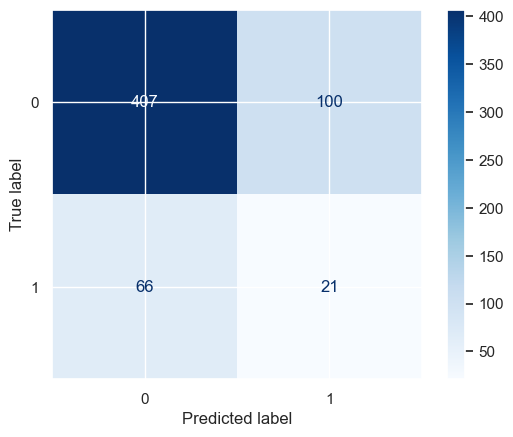

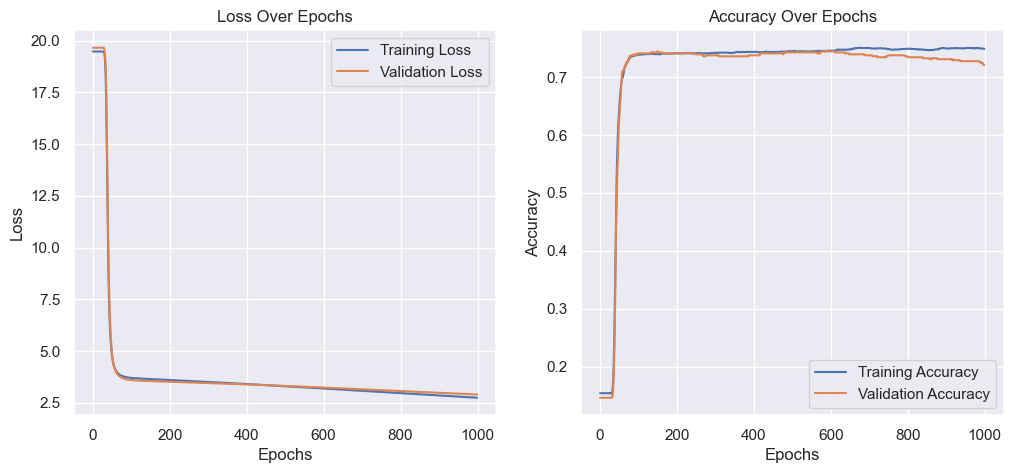


Test Accuracy: 0.7469


In [22]:
final_model = MyLogisticRegression(learning_rate=0.0001, epochs=1000, batch_size=X_train.shape[0])
final_model.fit(X_final_train.values, y_final_train.values, X_final_val.values, y_final_val.values)
final_model.evaluate_metrics(X_final_val.values, y_final_val.values)
final_model.plot_metrics()

test_pred = final_model.hypothesis(X_test)
test_pred_labels = (test_pred > 0.5).astype(int)

test_accuracy = np.mean(test_pred_labels.flatten() == y_test.values.flatten())
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# E: Analyzing Model Stability and Variance from Cross-Validation Results

- **Training vs. Validation Accuracy:**  
  - **Training Accuracy:** 0.7426 ± 0.0113  
    - The low standard deviation (±0.0113) suggests **high stability** in training performance across different folds.
  - **Validation Accuracy:** 0.7414 ± 0.0368  
    - A slightly higher variance (±0.0368) in validation accuracy indicates **mild instability** in generalization performance across folds, though the accuracy remains consistent with training.

- **Training vs. Validation Loss:**  
  - **Training Loss:** 2.4390 ± 0.3722  
    - Training loss shows moderate variation (±0.3722), suggesting **slight instability** during training across folds.
  - **Validation Loss:** 2.4627 ± 0.5827  
    - The higher standard deviation (±0.5827) indicates **greater variability** in validation loss.

- **Precision, Recall, and F1 Score:**  
  - **Precision:** 0.2004 ± 0.0639  
  - **Recall:** 0.2174 ± 0.0460  
  - **F1 Score:** 0.2071 ± 0.0523  
    - These metrics show **significant variation** across folds, especially precision (±0.0639). The instability here indicates that the model’s ability to correctly identify the positive class varies notably depending on the fold.

### Conclusion:  
While training accuracy is consistent across folds, there is some variance in validation accuracy and loss, suggesting potential issue is with dataset class imbalance. The high variance in precision and F1 score shows that the model's performance in handling the positive class is inconsistent across different data splits.

